# Sentiment classification with RoBERTa – Experiment C

**Task:** Binary sentiment classification.


**Model:** RoBERTa with a Multi-Layer Perceptron (MLP) head. The encoder is frozen, and only the classification head is trained.  


**Experiment:** Using the same 200k sample subset as Experiment B, this experiment freezes the RoBERTa encoder to isolate the contribution of the MLP classifier. It evaluates how effective the pretrained embeddings are for sentiment classification without fine-tuning the encoder.


In [1]:
%pip install gdown transformers datasets tensorflow scikit-learn tf-keras

## Dataset loading options

From Google Drive

In [2]:
file_id = "0Bz8a_Dbh9QhbZVhsUnRWRDhETzA"
output_name = 'amazon_review_full_csv.tar.gz'
!gdown --fuzzy https://drive.google.com/uc?id={file_id} -O {output_name}

Downloading...
From (original): https://drive.google.com/uc?id=0Bz8a_Dbh9QhbZVhsUnRWRDhETzA
From (redirected): https://drive.google.com/uc?id=0Bz8a_Dbh9QhbZVhsUnRWRDhETzA&confirm=t&uuid=acdb6888-e99b-4f73-8236-1a1300f5ac52
To: /content/amazon_review_full_csv.tar.gz
100% 644M/644M [00:14<00:00, 44.2MB/s]


In [3]:
import tarfile

with tarfile.open(output_name, "r:gz") as tar:
    tar.extractall("Dataset")

In [4]:
!ls -R Dataset

Dataset:
amazon_review_full_csv

Dataset/amazon_review_full_csv:
readme.txt  test.csv  train.csv


## Import Libraries

In [5]:
import pandas as pd
import json
import tensorflow as tf
import os
import time
import tf_keras as keras
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModel
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt


In [6]:
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
gpus = tf.config.list_physical_devices('GPU')
gpu_name = None
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    gpu_name = details.get('device_name', gpus[0].name)
else:
    gpu_name = 'CPU'

print(gpu_name)

NVIDIA A100-SXM4-40GB


## Model settings

In [8]:
MODEL_NAME    = "roberta-base"
BATCH_SIZE    = 32
EPOCHS        = 5
LEARNING_RATE = 2e-5
NUM_LABELS    = 2
RANDOM_STATE = 42
BASE_DIR_STORAGE = '/content/drive/MyDrive/HLT_models'

In [9]:
train_data_filename = "./Dataset/amazon_review_full_csv/train.csv"
test_data_filename = "./Dataset/amazon_review_full_csv/test.csv"

## Utilities Functions

### Data Loading and Extraction

In [10]:
def download_and_extract(file_id: str, output_name: str, extract_dir: str):

    os.system(f"gdown --fuzzy https://drive.google.com/uc?id={file_id} -O {output_name}")
    with tarfile.open(output_name, "r:gz") as tar:
        tar.extractall(extract_dir)

### Dataframe Building

In [11]:
def load_dataframe(path: str) -> pd.DataFrame:
    """
    Legge un CSV con colonne [label, title, text] e rimuove righe malformate.
    """
    df = pd.read_csv(
        path,
        header=None,
        names=["label","title","text"],
        quotechar='"', doublequote=True, escapechar='\\',
        engine='python', encoding='utf-8', on_bad_lines='skip'
    )
    return df

Remove NAN and filter by score 3

In [12]:
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.dropna()
    df = df[df['label'] != 3]
    return df.reset_index(drop=True)

### Mapping sentiment for binary classification

In [13]:
def map_sentiment(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['sentiment'] = df['label'].apply(lambda x: 0 if x <= 2 else 1)
    return df

### Text Construction and cleaning
Create column 'review' concatenating title and text. Replace newline with space

In [ ]:
def build_reviews(df: pd.DataFrame) -> pd.Series:
    reviews = df['title'].fillna('') + ' ' + df['text'].fillna('')
    return reviews

### Define Tokenization Class
This class contains functions to tokenize text and save encodings to allow performing 'una tantum tokenization'.


In [15]:
# --- Tokenization & Caching ---
class TokenCache:
    def __init__(self, max_len: int, cache_dir: str):
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        self.max_len = max_len
        os.makedirs(cache_dir, exist_ok=True)
        self.cache_dir = cache_dir

    def tokenize_and_save(self, texts: list[str], labels, sample_size: str):

        encodings = self.tokenizer(
            texts,
            max_length=self.max_len,
            truncation=True,
            padding='do_not_pad',
            return_attention_mask=True
        )

        os.makedirs(self.cache_dir, exist_ok=True)

        # save on disk
        np.savez_compressed(
            os.path.join(self.cache_dir,f"train_enc_{MODEL_NAME}_{sample_size}.npz"),
            ids   = np.array(encodings["input_ids"], dtype=object),
            attn  = np.array(encodings["attention_mask"], dtype=object),
            label = labels
        )

        npz_path = f"train_enc_{MODEL_NAME}_{sample_size}.npz"
        # save on temporary session
        np.savez_compressed(
            f"train_enc_{MODEL_NAME}_{sample_size}.npz",
            ids   = np.array(encodings["input_ids"], dtype=object),
            attn  = np.array(encodings["attention_mask"], dtype=object),
            label = labels
        )

        return npz_path

    def load_encodings(self, npz_path: str):
        return np.load(npz_path, allow_pickle=True)


### TF Dataset Preparation

In [16]:
def from_encodings_to_dataset(d: dict) -> tf.data.Dataset:

    def generator():
        for ids, attentions, labels in zip(d["ids"], d["attn"], d["label"]):
            yield {
                "input_ids":     np.array(ids,  dtype=np.int32),
                "attention_mask": np.array(attentions, dtype=np.int32)
        }, np.int32(labels)

    raw_ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            {"input_ids": tf.TensorSpec(shape=(None,), dtype=tf.int32),
             "attention_mask": tf.TensorSpec(shape=(None,), dtype=tf.int32)},
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    return raw_ds

### Manage Dynamic padding, batching and prefetch
The following function wraps two key steps into one reusable pipeline stage:
1. padded_batch(...)
	- Groups elements into batches of size BATCH_SIZE
	- Dynamically pads each batch’s input_ids and attention_mask to the length of the longest sequence in that batch
2.	.prefetch(tf.data.AUTOTUNE)
	- Overlaps data preparation and model execution to keep the GPU fed

In short: *prepare_dataset* turns a raw dataset of variable‐length examples into an efficient, dynamically‐padded, batched dataset ready for training.

Dynamic padding means that, instead of padding every sequence up to a fixed global MAX_LEN, you pad each batch only up to the length of its longest example.

In [17]:

def prepare_dataset(ds: tf.data.Dataset, pad_token_id: int, shuffle_buffer: int = None, repeat: bool = False) -> tf.data.Dataset:

    if shuffle_buffer:
        ds = ds.shuffle(buffer_size=shuffle_buffer, seed=RANDOM_STATE)

    ds = ds.padded_batch(
        BATCH_SIZE,
        padded_shapes=({"input_ids": [None], "attention_mask": [None]}, []),
        padding_values=({"input_ids": pad_token_id, "attention_mask": 0}, 0)
    )

    # in train set, during training without repeat, train set emits all batches only one time
    # if steps_for_epochs > real batches -> input ran out of data
    # with epochs > 1, at the second epoch there is nothing to read
    if repeat:
        ds = ds.repeat()

    return ds.prefetch(tf.data.AUTOTUNE)


## Training set preprocessing

In [18]:
df_train = load_dataframe(path=train_data_filename)

In [19]:
df_train.shape[0]

2999746

In [20]:
df_train.describe()

,label
count,2.999746e+06
mean,3.000022e+00
std,1.414218e+00
min,1.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,4.000000e+00
max,5.000000e+00


In [21]:
df_train.head()

,label,title,text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [22]:
df_train.isna().sum()

,0
label,0
title,188
text,0


In [23]:
df_train = clean_dataframe(df_train)

### Experiment with a subset of 200k samples

In [24]:
SAMPLE_SIZE = 200_000
BASE_DIR_STORAGE = os.path.join(BASE_DIR_STORAGE, f"{MODEL_NAME}_{SAMPLE_SIZE}")

In [25]:
df_train, _ = train_test_split(
    df_train,
    train_size=SAMPLE_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_train['label']
)
print(f"Train size: {len(df_train)}")

Train size: 200000


Let's check whether classes are balanced

In [26]:
print(df_train['label'].value_counts())

label
4    50002
5    50002
1    49999
2    49997
Name: count, dtype: int64


### Training set sentiment mapping

In [27]:
df_train = map_sentiment(df_train)

In [28]:
train_samples = build_reviews(df_train)
labels = df_train['sentiment'].values

### Setting Tokenizer

This approach uses the same tokenizer used during the model `MODEL_NAME` pretraining. This allow to preserve the context and language semantics.

`AutoTokenizer` is able to infer automatically the model used.


### Analyze tokens distribution to choose the best trade-off for MAX_LEN.
The idea is to use the 95th percentile to reduce padding and truncate only outliers.

In [29]:
N = len(train_samples)

if N < 10_000:
    n_samples = N
elif N < 100_000:
    n_samples = min(N, 5000)
else:
    n_samples = min(N, 10_000)


#  n_samples are good enough to get a stable estimation of tokens distribution
sample_texts = train_samples.sample(n=n_samples, random_state=RANDOM_STATE).tolist()

# Tokenize only for analysis (no padding required)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
token_lens = [len(tokenizer.tokenize(t)) for t in sample_texts]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

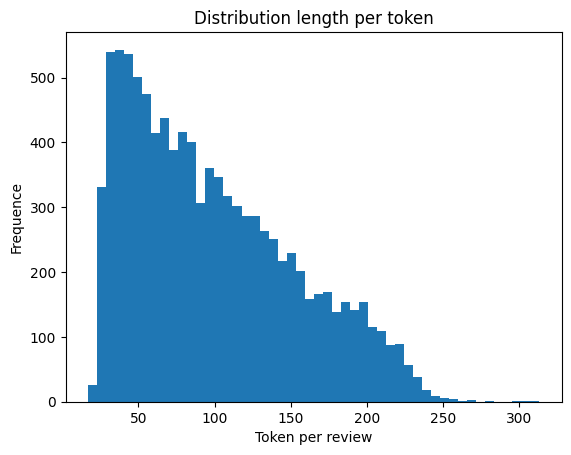

In [30]:
plt.hist(token_lens, bins=50)
plt.title("Distribution length per token")
plt.xlabel("Token per review")
plt.ylabel("Frequence")
plt.show()

In [31]:
print("Token length stats:")
print(f"Mean: {np.mean(token_lens):.1f}")
print(f"95th percentile: {np.percentile(token_lens, 95):.0f}")
print(f"Max: {np.max(token_lens)}")

Token length stats:
Mean: 98.8
95th percentile: 203
Max: 313


The 95th percentile of tokenized length is around ~200, meaning that 95% of the reviews are shorter than this threshold.

To balance memory efficiency and minimize information loss, we set `MAX_LEN = 205`:
- This truncates only the top 5% longest reviews (outliers).
- It reduces unnecessary padding for the remaining 95% of the data.
- It ensures consistent input size for the model without significant loss of content.

In [32]:
MAX_LEN = 205

In [33]:
train_samples.shape

(200000,)

### Una Tantum tokenization

In [34]:
cache = TokenCache(max_len=MAX_LEN, cache_dir= "/content/drive/MyDrive/Tokenization_cache")
npz_file = cache.tokenize_and_save(texts=train_samples.tolist(), labels=labels, sample_size=SAMPLE_SIZE)

Load encodings

In [35]:
encodings = cache.load_encodings(npz_file)

Create raw tf.data.Dataset from dictionary numpy of {input_ids, attention_mask, label}.

In [36]:
raw_ds  = from_encodings_to_dataset(encodings)

### Split raw Dataset

In [37]:
N = len(encodings['label'])
int_test_size = int(0.3 * N)
val_size  = int(0.2 * N)
train_size = N - int_test_size - val_size

print("Train size:", train_size)
print("Val   size:", val_size)
print("Test  size:", int_test_size)

Train size: 100000
Val   size: 40000
Test  size: 60000


In [38]:
ds_shuffled = raw_ds.shuffle(buffer_size=N, seed=RANDOM_STATE, reshuffle_each_iteration=False)
test_ds  = ds_shuffled.take(int_test_size)
reminder     = ds_shuffled.skip(int_test_size)
val_ds   = reminder.take(val_size)
train_ds = reminder.skip(val_size)

In [39]:
pad_id = cache.tokenizer.pad_token_id
# For train shuffle for each epoch and repeat
train = prepare_dataset(train_ds, pad_id, shuffle_buffer=train_size, repeat=True)
val   = prepare_dataset(val_ds, pad_id)
internal_test  = prepare_dataset(test_ds, pad_id)

### Checking for Overlap Between Train, Validation, and Test Splits

In [40]:
# We use a sample of 1000 to check statistically whether the 3 sets have any intersections
def sample_hashes(ds, n=1000):
    h = set()
    for ex, _ in ds.take(n):
        h.add(hash(ex["input_ids"].numpy().tobytes()))
    return h

h_tr = sample_hashes(train)
h_va = sample_hashes(val)
h_te = sample_hashes(internal_test)

print("Intersections between Train and Val  :", len(h_tr & h_va))
print("Intersection between Train and Test :", len(h_tr & h_te))
print("Intersections between Val and Test :", len(h_va & h_te))

Intersections between Train and Val  : 0
Intersection between Train and Test : 0
Intersections between Val and Test : 0


In [41]:
import math
steps_per_epoch   = math.ceil(train_size / BATCH_SIZE)
validation_steps  = math.ceil(val_size   / BATCH_SIZE)

## Choose whether retrain encoder or not

In [42]:
ENCODER_TRAINABLE = False

In [43]:
from keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [44]:
from transformers import TFRobertaModel
encoder = TFRobertaModel.from_pretrained(MODEL_NAME)
encoder.trainable = ENCODER_TRAINABLE


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

### Configuration of `roberta-base`

In [45]:
from transformers import AutoConfig
cfg = AutoConfig.from_pretrained("roberta-base")
print(cfg)

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [46]:
input_ids      = keras.Input(shape=(None,), dtype="int32", name="input_ids")
attention_mask = keras.Input(shape=(None,), dtype="int32", name="attention_mask")

Link to pretrained encoders info: https://huggingface.co/transformers/v2.4.0/pretrained_models.html

In [47]:
# executed for each batch
# here roberta converts input_ids into embedding vectors (batch_size, seq_len, hidden_size) where hidden_size = 768 for roberta-base.
encoder_outputs = encoder({'input_ids': input_ids, 'attention_mask': attention_mask})
pooled_output = encoder_outputs.pooler_output

# last hidden state is a tensor (batch_size, seq_len, hidden_size) containing the contextual representation of each token.
# cls is used to represent the entire sentence
# hidden_states = encoder_outputs.last_hidden_state
# cls_token = hidden_states[:, 0, :]

### Building Classification Head

In [48]:
x = keras.layers.Dense(256, activation='relu', name='dense_relu')(pooled_output)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(64, activation='relu')(x)


logits = keras.layers.Dense(1, name='logits')(x)


### Entire model

In [49]:
model = keras.Model(inputs=[input_ids, attention_mask], outputs=logits)

In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['attention_mask[0][0]',      
 aModel)                     ngAndCrossAttentions(last_   32         'input_ids[0][0]']           
                             hidden_state=(None, None,                                        

Check that encoder parameters are not retrainable

In [51]:
for i, layer in enumerate(model.layers):
    print(f"{layer.name:25s}  trainable={layer.trainable}")

attention_mask             trainable=True
input_ids                  trainable=True
tf_roberta_model           trainable=False
dense_relu                 trainable=True
dropout_37                 trainable=True
dense                      trainable=True
logits                     trainable=True


In [52]:
base_opt = keras.optimizers.AdamW(           # da tensorflow-addons
    learning_rate = LEARNING_RATE,
    weight_decay  = 1e-2,
    epsilon       = 1e-8,
    clipnorm      = 1.0,

)

optimizer = keras.mixed_precision.LossScaleOptimizer(base_opt)
loss= keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=[keras.metrics.BinaryAccuracy(name="accuracy")])

In [53]:
import time
start_time = time.time()

In [54]:
from tf_keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

In [55]:
history = model.fit(
    train,
    validation_data= val,
    epochs=EPOCHS,
    callbacks=[early_stop] ,
    validation_steps=validation_steps,
    steps_per_epoch=steps_per_epoch,

)

Epoch 1/5
3125/3125 [==============================] - 484s 130ms/step - loss: 0.6848 - accuracy: 0.5016 - val_loss: 0.6653 - val_accuracy: 0.4985
Epoch 2/5
3125/3125 [==============================] - 401s 128ms/step - loss: 0.6426 - accuracy: 0.5333 - val_loss: 0.6027 - val_accuracy: 0.6058
Epoch 3/5
3125/3125 [==============================] - 404s 129ms/step - loss: 0.5736 - accuracy: 0.6517 - val_loss: 0.5103 - val_accuracy: 0.7853
Epoch 4/5
3125/3125 [==============================] - 402s 129ms/step - loss: 0.5069 - accuracy: 0.7408 - val_loss: 0.4300 - val_accuracy: 0.8213
Epoch 5/5
3125/3125 [==============================] - 401s 128ms/step - loss: 0.4581 - accuracy: 0.7801 - val_loss: 0.3761 - val_accuracy: 0.8323
Restoring model weights from the end of the best epoch: 5.


In [56]:
end_time = time.time()
elapsed = end_time - start_time

print(f"Total training time: {elapsed:.1f} s ({elapsed/60:.2f} min)")

Total training time: 2092.6 s (34.88 min)


### Training History plot

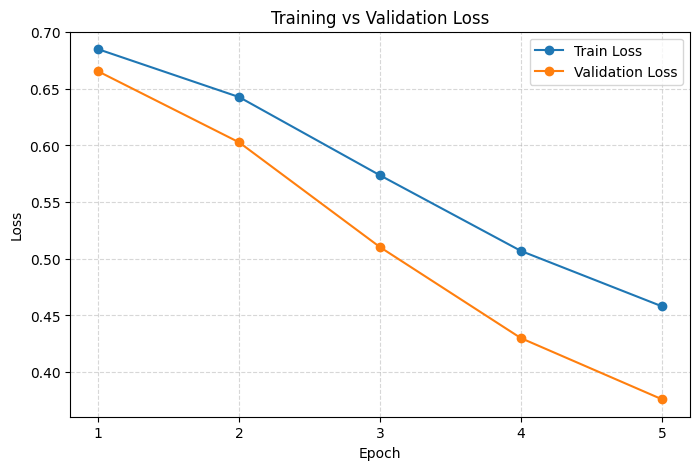

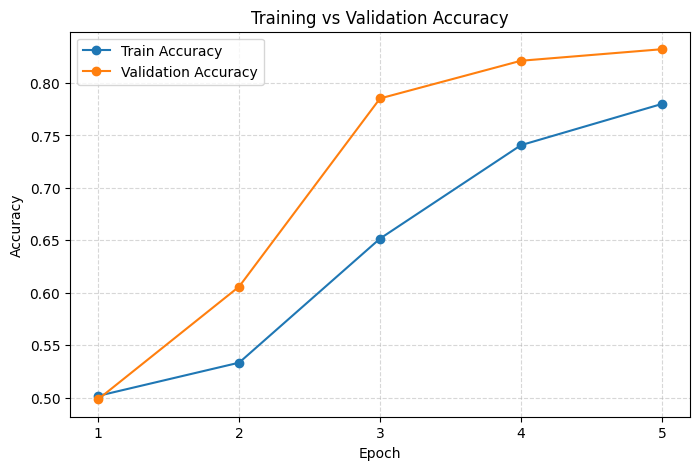

In [57]:
import matplotlib.pyplot as plt

# Estrai le liste di loss dal history
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
epochs     = range(1, len(train_loss) + 1)

train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']


# Disegna il plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss,   marker='o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)           # mostra tutte le epoche sull'asse x
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc,   marker='o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Model evaluation with Internal test set

In [58]:
y_true = np.concatenate([y for x, y in internal_test], axis=0)

pred_logits = model.predict(internal_test)
pred_probs  = tf.sigmoid(pred_logits).numpy().ravel()
pred_labels = (pred_probs >= 0.5).astype(int)

1875/1875 [==============================] - 172s 57ms/step


In [59]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

accuracy = accuracy_score(y_true, pred_labels)
precision = precision_score(y_true, pred_labels)
recall = recall_score(y_true, pred_labels)
f1 = f1_score(y_true, pred_labels)
cm = confusion_matrix(y_true, pred_labels)

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Accuracy: 0.8627
Precision: 0.8811
Recall: 0.8369
F1 Score: 0.8584
Test accuracy: 0.8627


### Confusion Matrix

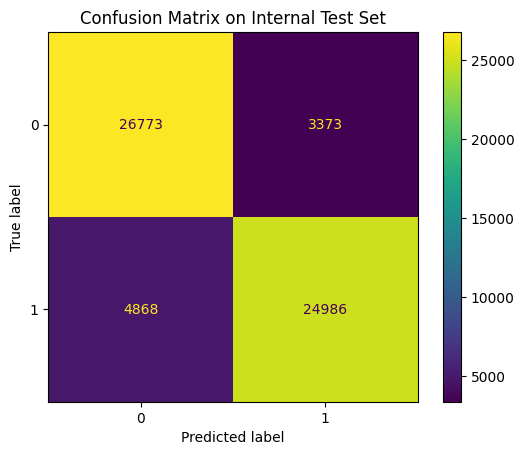

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(y_true, pred_labels)

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax)
ax.set_title("Confusion Matrix on Internal Test Set")
plt.show()

### Save model

In [61]:
os.makedirs(BASE_DIR_STORAGE, exist_ok=True)

file = os.path.join(BASE_DIR_STORAGE, f'roberta_{SAMPLE_SIZE}.keras')


model.save(file)
tokenizer.save_pretrained(BASE_DIR_STORAGE)

metadata = {
    "timestamp":          time.strftime("%Y-%m-%d %H:%M:%S"),
    "total_training_time_s": round(elapsed, 1),
    "num_samples":           SAMPLE_SIZE,
    "train_size":            train_size,
    "val_size":              val_size,
    "internal_test_size":    int_test_size,
    "batch_size":            BATCH_SIZE,
    "epochs":                EPOCHS,
    "encoder_trainable":     ENCODER_TRAINABLE,
    "history":               history.history,
    "gpu": gpu_name,
    "internal_test_accuracy": accuracy,

}

with open(os.path.join(BASE_DIR_STORAGE, f'training_metadata_roberta_{SAMPLE_SIZE}.json'), 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Saved model + tokenizer + metadata in {BASE_DIR_STORAGE}")

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Saved model + tokenizer + metadata in /content/drive/MyDrive/HLT_models/roberta-base_200000
